In [4]:
import os
import pandas as pd

data_dir = r"C:/Users/lenovo/Downloads/TrashBox_train_dataset_subfolders"

label_map = {
    'cardboard': 'Recyclable',
    'plastic': 'Recyclable',
    'paper': 'Recyclable',
    'metal': 'Recyclable',
    'glass': 'Recyclable',
    'medical': 'Non-Recyclable',
    'e-waste': 'Non-Recyclable'
}

filepaths = []
labels = []

# Loop over each top-level folder
for folder_name, label in label_map.items():
    folder_path = os.path.join(data_dir, folder_name)
    if not os.path.exists(folder_path):
        print(f"{folder_path} not found, skipping")
        continue

    # os.walk goes into subfolders automatically
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.jfif', '.bmp', '.webp')):
                filepaths.append(os.path.join(root, filename))
                labels.append(label)

df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

df.to_csv("trashnet_metadata.csv", index=False)
print("Saved CSV with", len(df), "rows")
print(df['label'].value_counts())
print(df.head())





Saved CSV with 14348 rows
label
Recyclable        10378
Non-Recyclable     3970
Name: count, dtype: int64
                                            filepath       label
0  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable
1  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable
2  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable
3  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable
4  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable


In [2]:
import os
data_dir = r"C:/Users/lenovo/Downloads/TrashBox_train_dataset_subfolders"
print(os.listdir(data_dir))


['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic']


In [3]:
import os

data_dir = r"C:/Users/lenovo/Downloads/TrashBox_train_dataset_subfolders"

for subfolder in ['medical', 'e-waste']:
    folder_path = os.path.join(data_dir, subfolder)
    if os.path.exists(folder_path):
        files = os.listdir(folder_path)
        print(subfolder, ":", len(files), "files, first few ->", files[:10])
    else:
        print(subfolder, "folder not found")


medical : 4 files, first few -> ['gloves', 'masks', 'medicines', 'syringe']
e-waste : 5 files, first few -> ['electrical cables', 'electronic chips', 'laptops', 'small appliances', 'smartphones']


In [11]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm  # optional, shows progress bar


In [12]:
# Load the CSV we just created
df = pd.read_csv("trashnet_metadata.csv")

# Quick check
print(df.head())
print(df['label'].value_counts())


                                            filepath       label
0  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable
1  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable
2  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable
3  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable
4  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable
label
Recyclable        10378
Non-Recyclable     3970
Name: count, dtype: int64


In [13]:
label_encoding = {'Recyclable': 1, 'Non-Recyclable': 0}
df['label_num'] = df['label'].map(label_encoding)

print(df.head())


                                            filepath       label  label_num
0  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable          1
1  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable          1
2  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable          1
3  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable          1
4  C:/Users/lenovo/Downloads/TrashBox_train_datas...  Recyclable          1


In [14]:
IMG_SIZE = 64  # you can try 128 later

def process_image(path):
    img = cv2.imread(path)          # read image
    if img is None:
        return None                 # skip if corrupted
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img.flatten()            # flatten to 1D array


In [15]:
features = []
labels = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    feat = process_image(row['filepath'])
    if feat is not None:
        features.append(feat)
        labels.append(row['label_num'])

# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels)

print("Feature array shape:", X.shape)
print("Labels shape:", y.shape)


100%|████████████████████████████████████████████████████████████████████████████| 14348/14348 [10:48<00:00, 22.12it/s]


Feature array shape: (14345, 12288)
Labels shape: (14345,)


In [16]:
np.save("features.npy", X)
np.save("labels.npy", y)


In [17]:
X = np.load("features.npy")
y = np.load("labels.npy")


In [18]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test, stratify to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (11476, 12288) (11476,)
Test shape: (2869, 12288) (2869,)


In [19]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Training completed!")


Training completed!


Test Accuracy: 0.79
                precision    recall  f1-score   support

Non-Recyclable       0.74      0.36      0.48       794
    Recyclable       0.79      0.95      0.87      2075

      accuracy                           0.79      2869
     macro avg       0.77      0.65      0.67      2869
  weighted avg       0.78      0.79      0.76      2869



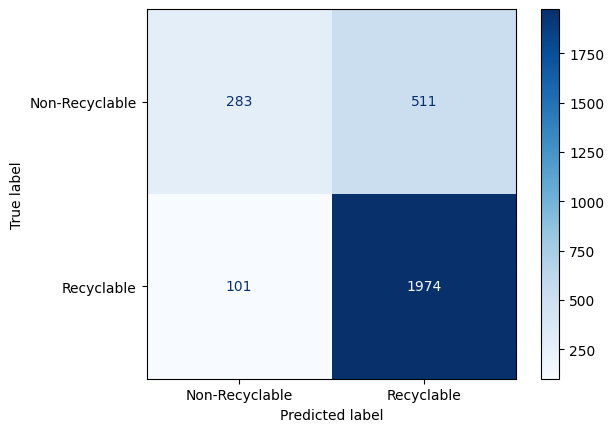

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions on test set
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.2f}")

# Classification report
print(classification_report(y_test, y_pred, target_names=['Non-Recyclable','Recyclable']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Recyclable','Recyclable'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [21]:
import joblib

joblib.dump(model, "rf_garbage_classifier.joblib")
print("Model saved as rf_garbage_classifier.joblib")


Model saved as rf_garbage_classifier.joblib


In [22]:
model = joblib.load("rf_garbage_classifier.joblib")


In [28]:
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt


In [24]:
# Load your previously saved Random Forest model
model = joblib.load("rf_garbage_classifier.joblib")


In [30]:
def preprocess_image(image_path):   # just a variable name here
    import cv2
    import numpy as np

    IMG_SIZE = 64  # same as training
    img = cv2.imread(image_path)
    if img is None:
        print("Error: image not found or cannot be read.")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img.flatten().reshape(1, -1)  # reshape for model


SyntaxError: unexpected character after line continuation character (2499951607.py, line 3)

Predicted label: Recyclable


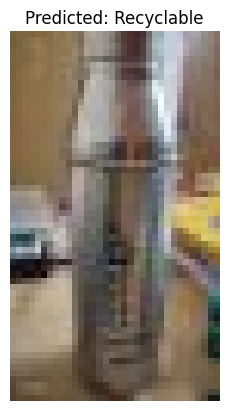

In [31]:
# Example: path to a new image
new_image_path = r"C:\Users\lenovo\OneDrive\Pictures\bottle.jpg"

X_new = preprocess_image(new_image_path)
if X_new is not None:
    pred = model.predict(X_new)[0]
    label_map = {1: 'Recyclable', 0: 'Non-Recyclable'}
    predicted_label = label_map[pred]
    print(f"Predicted label: {predicted_label}")

    # Display image with label
    img = cv2.imread(new_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
